# $^{83m}Kr$ LCE Maps: PAX w/ old binning

_Ted Berger; sometime in May?_

In [2]:
# import libraries

import ROOT
from math import pi
import math
from collections import defaultdict
import numpy as np
import pandas as pd
from IPython.display import Image

from pax import core, simulation, units, dsputils
import pax

import hax
# hax.init(main_data_paths=['/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2/'],
#          raw_data_local_path='/project/lgrandi/tunnell/')

#hax.ipython.code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
class Kr83m_Basic(hax.minitrees.TreeMaker):
    
    __version__ = '0.0.1'
    extra_branches = ['dataset_name','peaks.n_contributing_channels','peaks.hit_time_mean']
    
    def extract_data(self, event):
        
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Extract dataset_number
        dsetname = event.dataset_name
        if dsetname.endswith('.xed'):
            filename = dsetname.split("/")[-1]
            _, date, time, _ = filename.split('_')
            dataset_number = int(date) * 1e4 + int(time)
        else:
            # TODO: XENON1T support
            dataset_number = 0
            
        event_data = dict(event_number=event.event_number,
                          event_time=event.start_time,
                          dataset_number=dataset_number)
        
        # shortcuts for pax classes
        peaks = event.peaks
        interactions = event.interactions
        
        # assume 1st kr signal is interactions[0]
        s10 = interactions[0].s1
        s20 = interactions[0].s2
        
        # find 2nd kr interaction
        krInt = [0,0]  
        for i, interaction in enumerate(interactions):
            if interaction.s1 != s10 and interaction.s2 == s20 and krInt[0] == 0:
                krInt[0] = i
            elif interaction.s1 != s10 and interaction.s2 != s20 and krInt[1] == 0:
                krInt[1] = i
    
        # Distinction b/w single and double s2 events
        # Cut events without second s1
        if krInt[1] != 0:
            s11 = interactions[krInt[1]].s1
            s21 = interactions[krInt[1]].s2
            sInt = krInt[1]
        elif krInt[0] != 0:
            s11 = interactions[krInt[0]].s1
            s21 = -1
            sInt = krInt[0]
        else: return dict()
                
        # Find additional unwanted peaks
        s12 = -1
        for s1 in event.s1s:
            if s1 not in [s10,s11]: 
                s12 = s1
                break
        s22 = -1
        for s2 in event.s2s:
            if s2 not in [s20,s21]:
                s22 = s2
                break
                
        ##### Grab Data #####
    
        event_data.update(dict( s10Area = peaks[s10].area,
                                cs10Area = peaks[s10].area*interactions[0].s1_area_correction,
                                s10Coin = peaks[s10].n_contributing_channels,
                                s10Time = peaks[s10].hit_time_mean,
                                s10x = interactions[0].x,
                                s10y = interactions[0].y,
                                s10z = interactions[0].z,
                                s20Area = peaks[s20].area,
                                cs20Area = peaks[s20].area*interactions[0].s2_area_correction,
                                s20Coin = peaks[s20].n_contributing_channels,
                                s20Time = peaks[s20].hit_time_mean,
                                s11Area = peaks[s11].area,
                                cs11Area = peaks[s11].area*interactions[sInt].s1_area_correction,
                                s11Coin = peaks[s11].n_contributing_channels,
                                s11Time = peaks[s11].hit_time_mean,
                                s11x = interactions[sInt].x,
                                s11y = interactions[sInt].y,
                                s11z = interactions[sInt].z ))
    
        if s21 != -1:
            s21Area = peaks[s21].area
            s21Coin = peaks[s21].n_contributing_channels
            s21Time = peaks[s21].hit_time_mean
        else:
            s21Area = 0
            s21Coin = 0
            s21Time = 0
    
        if s12 != -1:
            s12Area = peaks[s12].area
            s12Coin = peaks[s12].n_contributing_channels
            s12Time = peaks[s12].hit_time_mean
        else:
            s12Area = 0
            s12Coin = 0
            s12Time = 0
        
        if s22 != -1:
            s22Area = peaks[s22].area
            s22Coin = peaks[s22].n_contributing_channels
            s22Time = peaks[s22].hit_time_mean
        else:
            s22Area = 0
            s22Coin = 0
            s22Time = 0
            
        event_data.update(dict( s21Area = s21Area,
                                s21Coin = s21Coin,
                                s21Time = s21Time,
                                s12Area = s12Area,
                                s12Coin = s12Coin,
                                s12Time = s12Time,
                                s22Area = s22Area,
                                s22Coin = s22Coin,
                                s22Time = s22Time ))
        
        return event_data        

In [4]:
# Kr83m data subset already re-processed by pax

dataset = ['xe100_150413_1839'
           ,'xe100_150414_1535'
           ,'xe100_150419_1611'
           ,'xe100_150420_0304'
           ,'xe100_150420_1809']

In [5]:
data = hax.minitrees.load(dataset, treemakers=Kr83m_Basic)
data = data[data['s10Time']>=0]

Found minitree at ./xe100_150413_1839_Kr83m_Basic.root
Found minitree at ./xe100_150414_1535_Kr83m_Basic.root
Found minitree at ./xe100_150419_1611_Kr83m_Basic.root
Found minitree at ./xe100_150420_0304_Kr83m_Basic.root
Found minitree at ./xe100_150420_1809_Kr83m_Basic.root


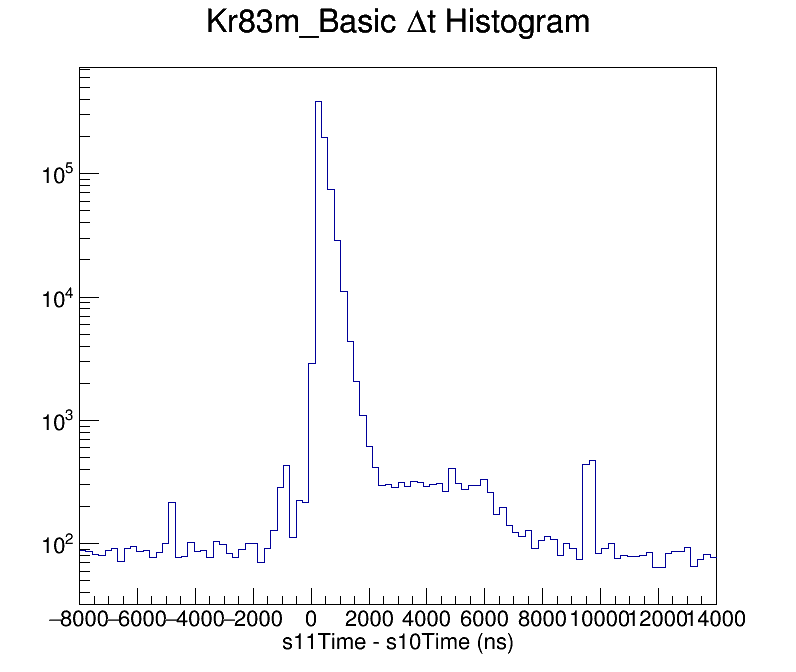

In [6]:
dtH = ROOT.TH1D("","", 100, -8000, 14000)
for i in range(len(data)):
    dt = data['s11Time'].values[i] - data['s10Time'].values[i]
    dtH.Fill(dt)
    
c1 = ROOT.TCanvas("","", 800, 700 )
c1.SetLogy()
ROOT.gStyle.SetOptStat(0)

dtH.SetTitle('Kr83m_Basic #Deltat Histogram')
dtH.GetXaxis().SetTitle('s11Time - s10Time (ns)')
dtH.GetXaxis().CenterTitle()
dtH.Draw('hist')

c1.Print('f_dtFull.png')
c1.Clear()
Image(filename='f_dtFull.png')

In [13]:
df = data[ (data['s10Coin']>=3) & (data['s20Coin']>=4) & (data['s11Coin']>=2) & 
           ((data['s21Area']==0) | (data['s21Area']>=200)) & (data['s11Area']>7) &
           (data['s11Time']-data['s10Time']>0)]

#CREATES AND FILLS BINS

def atan(y, x):
    phi = np.arctan2(y, x)
    for i in range(len(phi)):
        if phi[i] < 0: 
            phi[i] += 2*np.pi
    return phi

R = 15.25
Z = 30.3
N_z = 10
z_0 = Z/N_z
N_phi = [10, 15, 20, 40, 60]
phi_0 = [2*pi/10, 2*pi/15, 2*pi/20, 2*pi/40, 2*pi/60]
A_r = [R/5, 2*R/5, 3*R/5, 4*R/5, R]

bin_data = defaultdict(list)

for z_i in range(N_z):
    z_min = z_i * z_0
    z_max = (z_i+1) * z_0
    df_z = df[ (df['s11z']>z_min) & (df['s11z']<=z_max) ]
    for r_i in range(len(A_r)):
        if r_i == 0:
            r_min = 0
        else:
            r_min = A_r[r_i-1]
        r_max = A_r[r_i]
        df_r = df_z[ ( np.sqrt(df_z['s11x']**2 + df_z['s11y']**2)>r_min )
                            & ( np.sqrt(df_z['s11x']**2 + df_z['s11y']**2)<=r_max )]
        for phi_i in range(N_phi[r_i]):
            bin_data['z_i'].append(z_i)
            bin_data['z'].append( (z_max + z_min)/2 )
            bin_data['r_i'].append(r_i)
            bin_data['r'].append( (r_max + r_min)/2 )
            bin_data['phi_i'].append(phi_i)
            phi_min = phi_i * phi_0[r_i] 
            phi_max = (phi_i+1) * phi_0[r_i] 
            bin_data['phi'].append( (phi_max + phi_min)/2 )
            df_phi = df_r[ (atan(df_r['s10y'].values, df_r['s11x'].values) > phi_min) & (atan(df_r['s11y'].values, df_r['s11x'].values) <= phi_max )]
            bin_data['N'].append(len(df_phi))
            
            #bin hists
            c1 = ROOT.TCanvas('','', 800, 700)
            hist = ROOT.TH1D('','', 100, 0, 100)
            for i in range(len(df_phi['s11Area'])):
                hist.Fill(df_phi['s11Area'].values[i])
            hist.SetTitle('9 keV Spectrum: %.1f < z < %.1f, %.1f < r < %.1f, %.1f < phi < %.1f,'\
                          %(z_min, z_max, r_min, r_max, phi_min, phi_max))
            hist.GetXaxis().SetTitle('s11Area (pe)')
            hist.GetXaxis().CenterTitle()
            hist.Sumw2()
            hist.SetStats(False)
            hist.Draw()
            hist.Fit('gaus')
            fit = hist.GetFunction('gaus')
            chi2 = fit.GetChisquare()
            ndf = fit.GetNDF()
            p0 = fit.GetParameter(0)
            e0 = fit.GetParError(0)
            p1 = fit.GetParameter(1)
            e1 = fit.GetParError(1)
            p2 = fit.GetParameter(2)
            e2 = fit.GetParError(2)
            
            pt = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
            pt.AddText('Entries = %d'%len(df_phi))
            pt.AddText('#mu = %1.3f #pm %1.3f'%(p1, e1))
            pt.AddText('#sigma = %1.3f #pm %1.3f' %(p2, e2))
            pt.AddText('Amplitude = %1.3f #pm %1.3f' %(p0, e0))
            pt.AddText('#chi^{2}/NDF = %1.3f/%1.3f' %(chi2, ndf))
            
            
            pt.Draw()
            
            c1.Print('Bin_Hists/f_z%d_r%d_phi%d.png' %(z_i, r_i, phi_i))
            c1.Clear()
            hist.Delete()
            
            bin_data['<s11Area>'].append(p1)
            bin_data['error'].append(e1)
            
            
            

In [16]:
df2 = pd.DataFrame(bin_data)

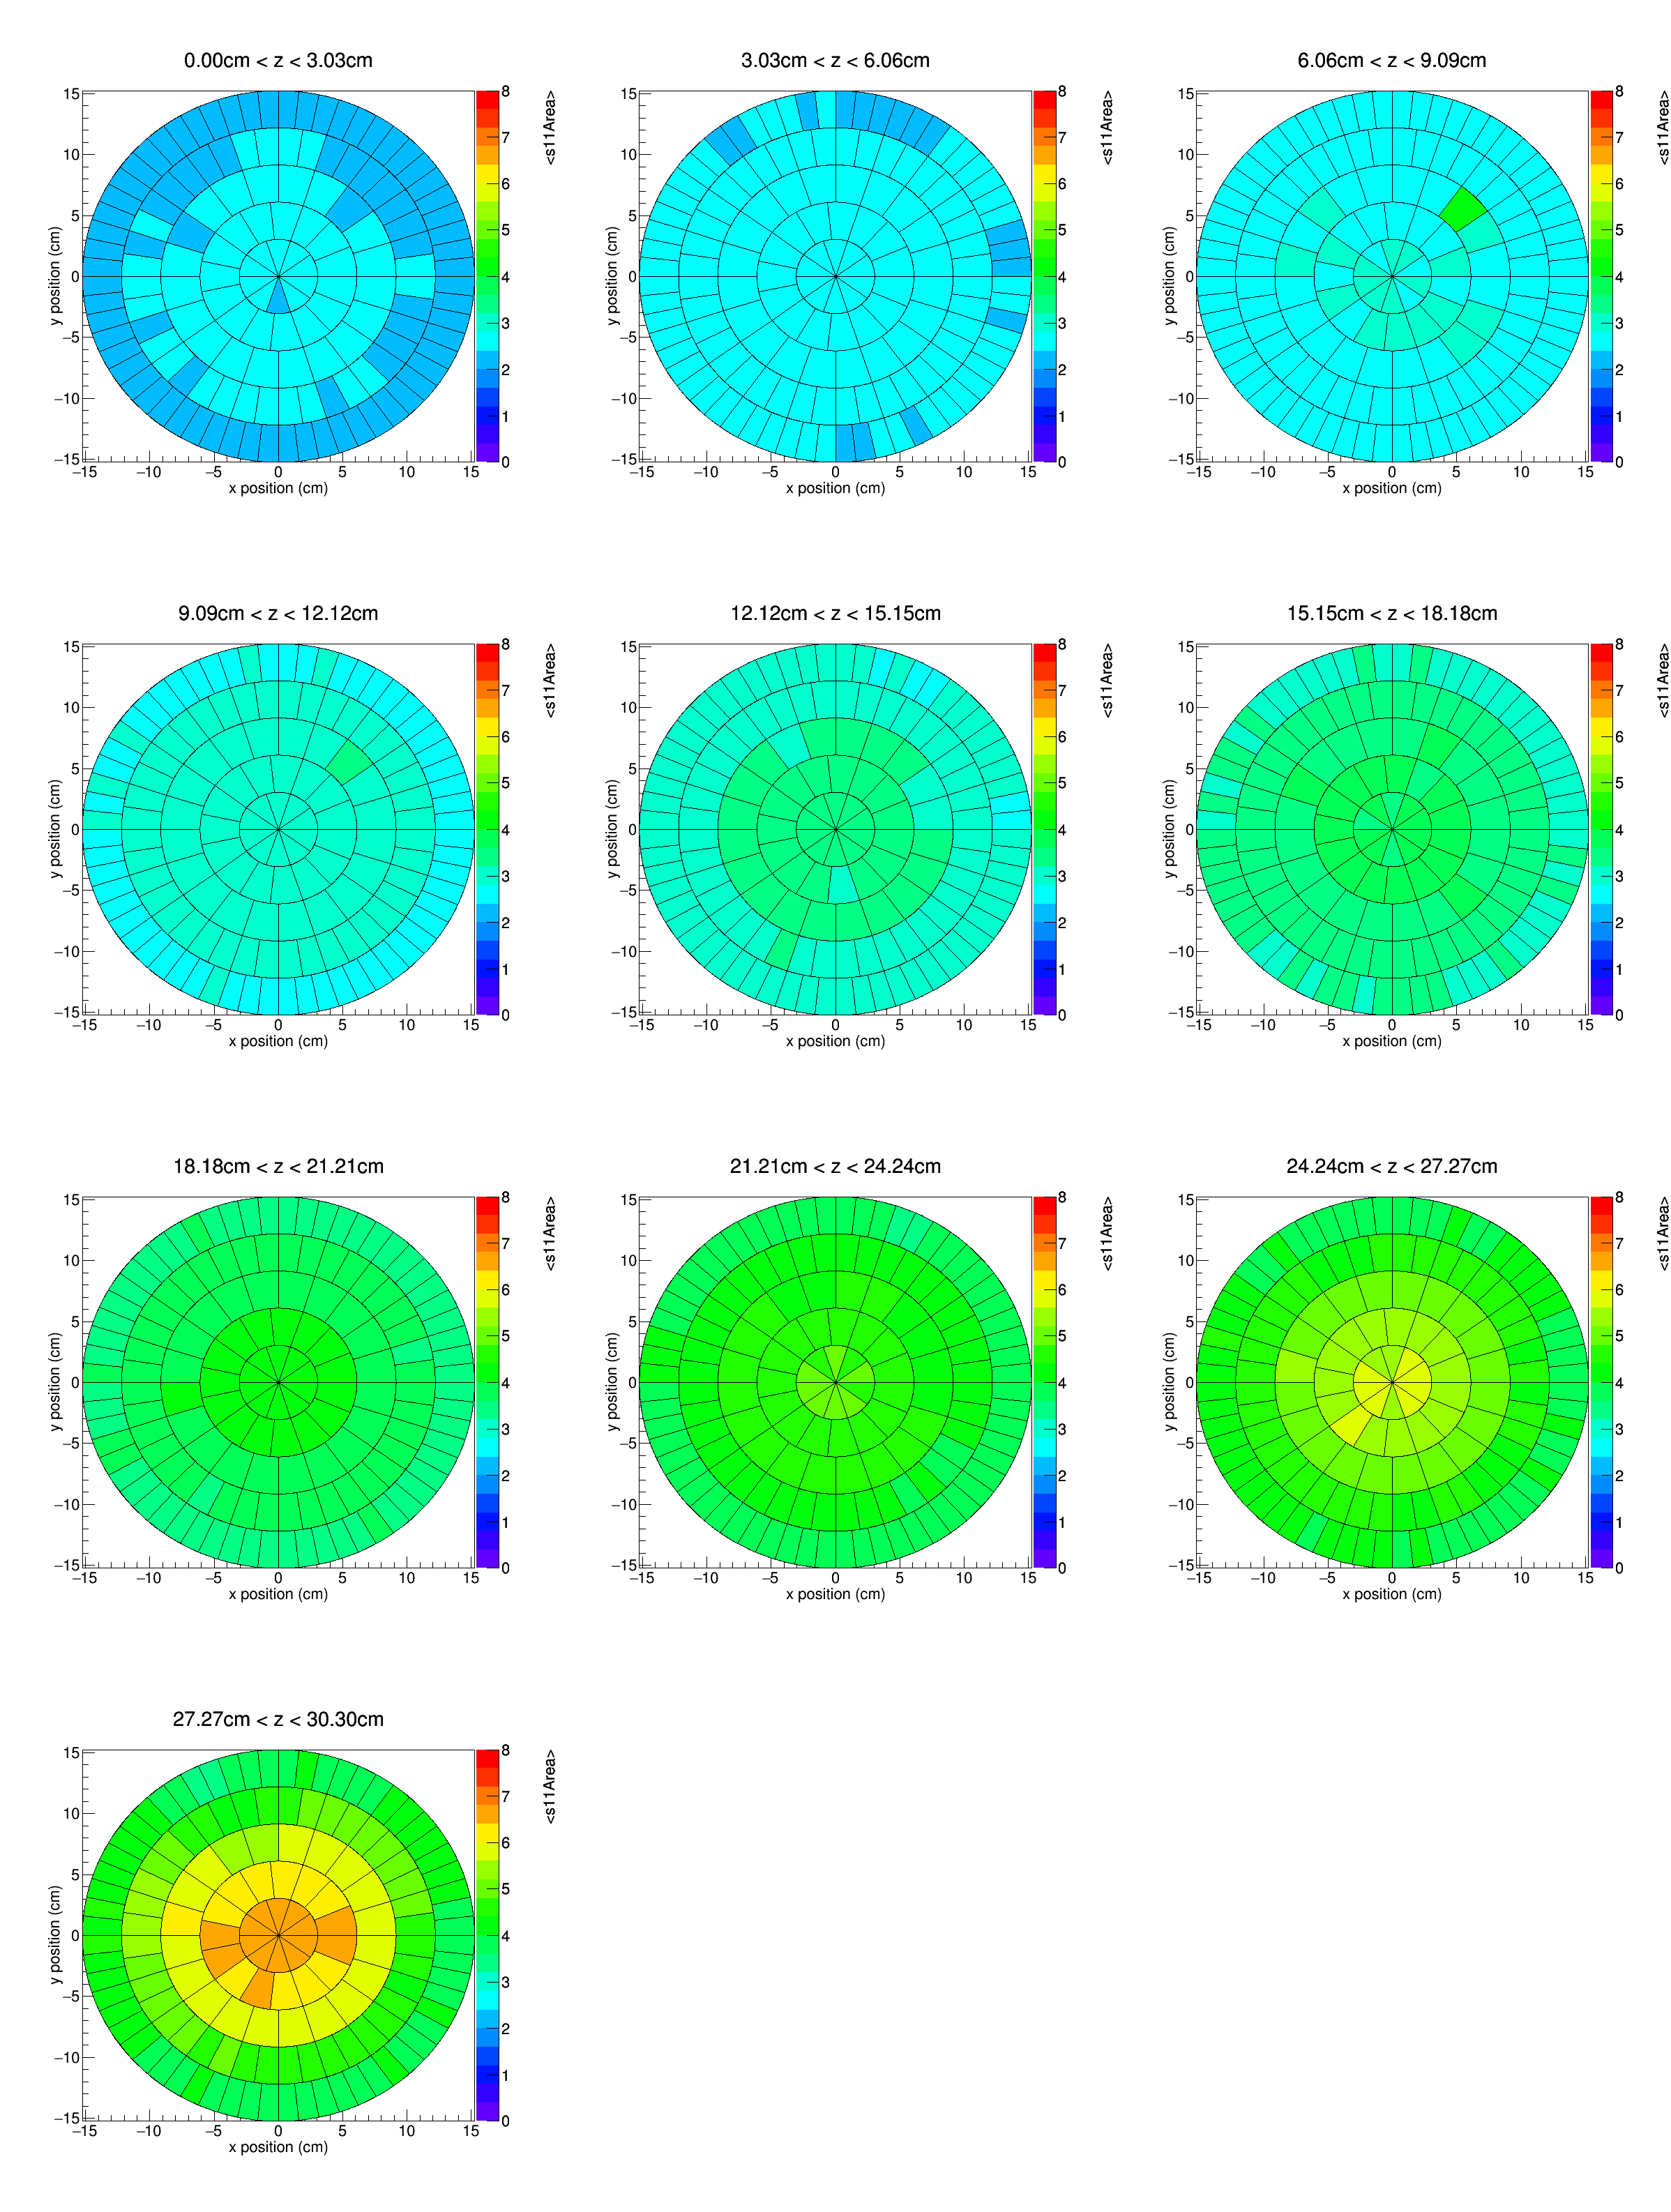

In [21]:
#declare and fill hist for each z_i

dummyH_list=[]

c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
c1.Divide(3,4,0.02,0.02)

z_hists = []

for z_i in range(N_z):
    dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))
    
    df2_new = df2[ df2['z_i'] == z_i ]
    hists = []
    for r_i in range(len(A_r)):
        hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
        df2_newer = df2_new[ df2_new['r_i'] == r_i ]
        for i in range(len(df2_newer)):
            hists[r_i].Fill(df2_newer['phi'].values[i], df2_newer['r'].values[i],
                            df2_newer['<s11Area>'].values[i]/9.4 )
            
    z_hists.append(hists)
                  
    c1.cd(z_i+1)
    
    dummyH_list[z_i].Draw('colz')
    dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
    dummyH_list[z_i].GetZaxis().SetTitle("<s11Area>")
    dummyH_list[z_i].GetXaxis().SetTitle("x position (cm)")
    dummyH_list[z_i].GetXaxis().CenterTitle()
    dummyH_list[z_i].GetYaxis().SetTitle("y position (cm)")
    dummyH_list[z_i].GetYaxis().CenterTitle()
    
#     c1.SetTopMargin(0.2)
    c1.SetRightMargin(0.2)
    
    for i in range(len(z_hists[z_i])):
        z_hists[z_i][i].GetZaxis().SetRangeUser(0, 8)
        z_hists[z_i][i].GetZaxis().SetTitle("<s11Area>")
        z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
        z_hists[z_i][i].Draw('pol colz a same') 
            
c1.Print('f_full_LY_s11.png')
c1.Clear()
    
 
Image(filename='f_full_LY_s11.png')
    
  

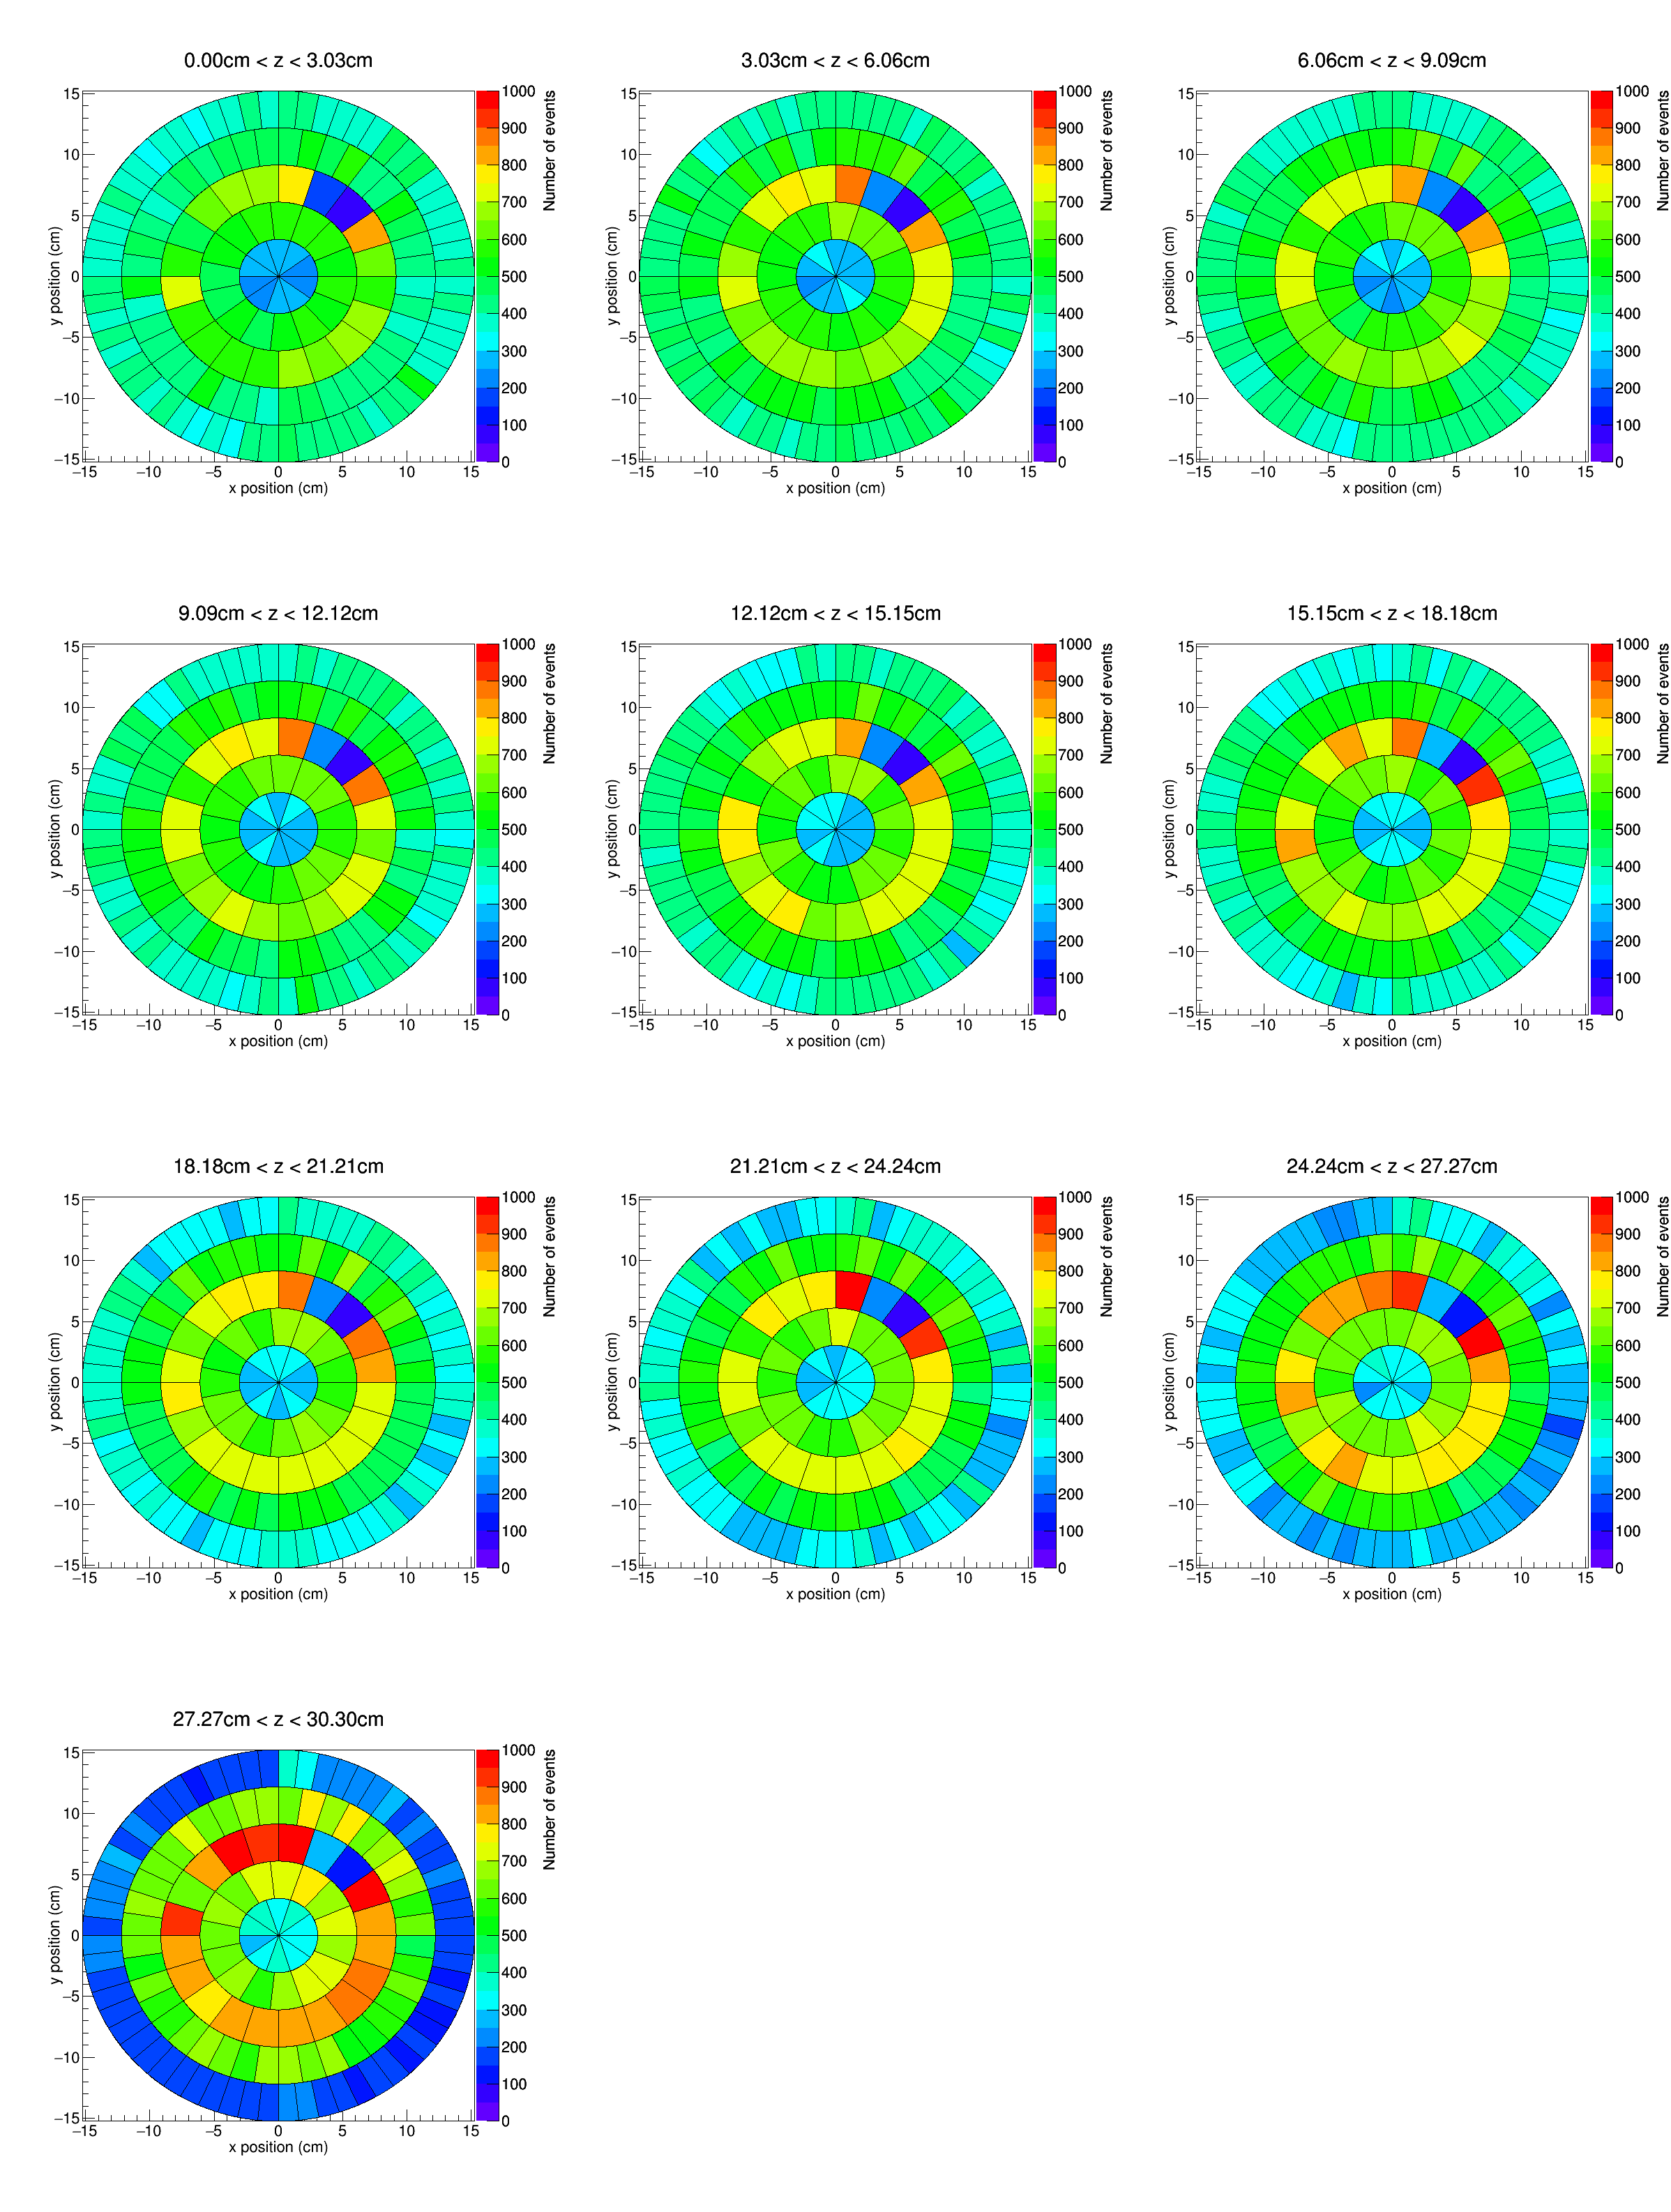

In [22]:
#declare and fill hist for each z_i

dummyH_list=[]

c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
c1.Divide(3,4,0.02,0.02)

z_hists = []

for z_i in range(N_z):
    dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))
    
    df2_new = df2[ df2['z_i'] == z_i ]
    hists = []
    for r_i in range(len(A_r)):
        hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
        df2_newer = df2_new[ df2_new['r_i'] == r_i ]
        for i in range(len(df2_newer)):
            hists[r_i].Fill(df2_newer['phi'].values[i], df2_newer['r'].values[i],
                            df2_newer['N'].values[i] )
            
    z_hists.append(hists)
                  
    c1.cd(z_i+1)
    
    dummyH_list[z_i].Draw('colz')
    dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
    dummyH_list[z_i].GetZaxis().SetTitle("Nu")
    dummyH_list[z_i].GetXaxis().SetTitle("x position (cm)")
    dummyH_list[z_i].GetXaxis().CenterTitle()
    dummyH_list[z_i].GetYaxis().SetTitle("y position (cm)")
    dummyH_list[z_i].GetYaxis().CenterTitle()
    
#     c1.SetTopMargin(0.2)
    c1.SetRightMargin(0.2)
    
    for i in range(len(z_hists[z_i])):
        z_hists[z_i][i].GetZaxis().SetRangeUser(0, 1000)
        z_hists[z_i][i].GetZaxis().SetTitle("Number of events")
        z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
        z_hists[z_i][i].Draw('pol colz a same') 

c1.SetTitle("Average S10 Area per Bin")
            
c1.Print('f_full_LY_N.png')
c1.Clear()
    
 
Image(filename='f_full_LY_N.png')
    
  